## Tuning hyperparameters for different ML models

In this notebook, we will use the define-by-run framework to optimize the hyperparameters of various machine learning models from Scikit-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

import optuna

In [2]:
# load dataset

X, y = load_breast_cancer(return_X_y=True, as_frame=True)
y = y.map({0:1, 1:0})

X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# the target:
# percentage of benign (0) and malign tumors (1)

y.value_counts() / len(y)

target
0    0.627417
1    0.372583
Name: count, dtype: float64

In [4]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

## Define the objective function

This is the hyperparameter response space, the function we want to optimize.

In [5]:
# the objective function takes the hyperparameter space
# as input

def objective(trial):
    
    classifier_name = trial.suggest_categorical("classifier", ["logit", "RF", 'GBM'])
    
    if classifier_name == "logit":
        
        logit_penalty = trial.suggest_categorical('logit_penalty', ['l1','l2'])
        logit_c = trial.suggest_float('logit_c', 0.001, 10)
        logit_solver = 'saga'
        
        model = LogisticRegression(
            penalty=logit_penalty,
            C=logit_c,
            solver=logit_solver,
        )
        
    elif classifier_name =="RF":
        
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 100, 1000)
        rf_criterion = trial.suggest_categorical("rf_criterion", ['gini', 'entropy'])
        rf_max_depth = trial.suggest_int("rf_max_depth", 1, 4)
        rf_min_samples_split = trial.suggest_float("rf_min_samples_split", 0.01, 1)

        model = RandomForestClassifier(
            n_estimators=rf_n_estimators,
            criterion=rf_criterion,
            max_depth=rf_max_depth,
            min_samples_split=rf_min_samples_split,
        )
        
    else:
        
        gbm_n_estimators = trial.suggest_int("gbm_n_estimators", 100, 1000)
        gbm_criterion = trial.suggest_categorical("gbm_criterion", ['squared_error', 'friedman_mse'])
        gbm_max_depth = trial.suggest_int("gbm_max_depth", 1, 4)
        gbm_min_samples_split = trial.suggest_float("gbm_min_samples_split", 0.01, 1)

        model = GradientBoostingClassifier(
            n_estimators=gbm_n_estimators,
            criterion=gbm_criterion,
            max_depth=gbm_max_depth,
            min_samples_split=gbm_min_samples_split,
        )

    
    score = cross_val_score(model, X_train, y_train, cv=3)
    accuracy = score.mean()
    
    return accuracy

## TPE

TPESampler is the default

In [6]:
study = optuna.create_study(
    direction="maximize",
    # we do not need the below line, 
    # tpe is the default search
    sampler=optuna.samplers.TPESampler(),
)


study.optimize(objective, n_trials=20)

[I 2024-09-19 12:55:13,442] A new study created in memory with name: no-name-e0238e4f-5396-44e9-afef-3fa4435560eb
[I 2024-09-19 12:55:36,820] Trial 0 finished with value: 0.9648363332573858 and parameters: {'classifier': 'GBM', 'gbm_n_estimators': 700, 'gbm_criterion': 'friedman_mse', 'gbm_max_depth': 3, 'gbm_min_samples_split': 0.7347616205138058}. Best is trial 0 with value: 0.9648363332573858.
[I 2024-09-19 12:55:43,520] Trial 1 finished with value: 0.9196476038581302 and parameters: {'classifier': 'RF', 'rf_n_estimators': 300, 'rf_criterion': 'entropy', 'rf_max_depth': 1, 'rf_min_samples_split': 0.47995876936706344}. Best is trial 0 with value: 0.9648363332573858.
[I 2024-09-19 12:55:58,186] Trial 2 finished with value: 0.9673425989215462 and parameters: {'classifier': 'GBM', 'gbm_n_estimators': 461, 'gbm_criterion': 'friedman_mse', 'gbm_max_depth': 3, 'gbm_min_samples_split': 0.6849266478342732}. Best is trial 2 with value: 0.9673425989215462.
C:\Users\Sole\Documents\Repositories\

In [7]:
study.best_params

{'classifier': 'GBM',
 'gbm_n_estimators': 131,
 'gbm_criterion': 'squared_error',
 'gbm_max_depth': 3,
 'gbm_min_samples_split': 0.8565591359435581}

In [8]:
study.best_value

0.9723361433887749

In [9]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_classifier,params_gbm_criterion,params_gbm_max_depth,params_gbm_min_samples_split,params_gbm_n_estimators,params_logit_c,params_logit_penalty,params_rf_criterion,params_rf_max_depth,params_rf_min_samples_split,params_rf_n_estimators,state
0,0,0.964836,2024-09-19 12:55:13.447375,2024-09-19 12:55:36.819541,0 days 00:00:23.372166,GBM,friedman_mse,3.0,0.734762,700.0,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
1,1,0.919648,2024-09-19 12:55:36.824541,2024-09-19 12:55:43.519699,0 days 00:00:06.695158,RF,NaN,NaN,NaN,NaN,NaN,NaN,entropy,1.0,0.479959,300.0,COMPLETE
2,2,0.967343,2024-09-19 12:55:43.522698,2024-09-19 12:55:58.185288,0 days 00:00:14.662590,GBM,friedman_mse,3.0,0.684927,461.0,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
3,3,0.912015,2024-09-19 12:55:58.187287,2024-09-19 12:55:58.482118,0 days 00:00:00.294831,logit,NaN,NaN,NaN,NaN,3.522249,l1,NaN,NaN,NaN,NaN,COMPLETE
4,4,0.912015,2024-09-19 12:55:58.487115,2024-09-19 12:55:58.733977,0 days 00:00:00.246862,logit,NaN,NaN,NaN,NaN,2.206415,l2,NaN,NaN,NaN,NaN,COMPLETE
5,5,0.972336,2024-09-19 12:55:58.735974,2024-09-19 12:56:02.602299,0 days 00:00:03.866325,GBM,squared_error,3.0,0.856559,131.0,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
6,6,0.959805,2024-09-19 12:56:02.605299,2024-09-19 12:56:11.510191,0 days 00:00:08.904892,GBM,squared_error,3.0,0.629993,270.0,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
7,7,0.957318,2024-09-19 12:56:11.511190,2024-09-19 12:56:36.505859,0 days 00:00:24.994669,GBM,squared_error,4.0,0.385167,971.0,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
8,8,0.912015,2024-09-19 12:56:36.507855,2024-09-19 12:56:36.790692,0 days 00:00:00.282837,logit,NaN,NaN,NaN,NaN,5.355671,l1,NaN,NaN,NaN,NaN,COMPLETE
9,9,0.912015,2024-09-19 12:56:36.791692,2024-09-19 12:56:37.058538,0 days 00:00:00.266846,logit,NaN,NaN,NaN,NaN,7.702439,l1,NaN,NaN,NaN,NaN,COMPLETE


In [10]:
results = study.trials_dataframe()

results['params_classifier'].value_counts()

params_classifier
GBM      12
RF        4
logit     4
Name: count, dtype: int64

The search quickly realised that GBM returned the best performance, so explored the hyperparameter space for that model more than for the others.

In [11]:
results.groupby(['params_classifier'])['value'].agg(['mean', 'std'])

,mean,std
params_classifier,,
GBM,0.961058,0.007603
RF,0.771384,0.168308
logit,0.912015,0.000000


Text(0, 0.5, 'Accuracy')

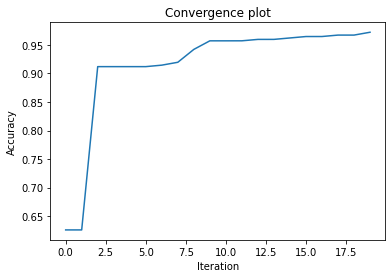

In [12]:
results['value'].sort_values().reset_index(drop=True).plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')